In [27]:
import pandas as pd

csv_df = pd.read_csv('wheat-coords/wheat-coords-2023.csv')
csv_df.head()

,longitude,latitude
0,-104.047592,50.172724
1,-108.704745,51.628192
2,-108.565619,51.853696
3,-107.204838,52.415060
4,-101.747376,49.540832


In [28]:
import requests

sample = csv_df.sample(5)

i = 0
data = []
for entry in sample.itertuples():
    i += 1
    if i > 5:
        break

    payload = {
        "latitude": entry.latitude,
        "longitude": entry.longitude,
        "year": 2022
    }
    print("Requesting:", payload)
    r = requests.post("http://127.0.0.1:5000/getData", json=payload, timeout=10)
    r.raise_for_status()
    data.append(r.json())

with open('data.json', 'w') as f:
    import json
    json.dump(data, f, indent=2)

Requesting: {'latitude': 53.433862061255155, 'longitude': -110.83436017637388, 'year': 2022}
Requesting: {'latitude': 53.108933989554, 'longitude': -112.50193800562349, 'year': 2022}
Requesting: {'latitude': 50.915430957346, 'longitude': -107.58933874132218, 'year': 2022}
Requesting: {'latitude': 55.87068945177026, 'longitude': -119.01548565323168, 'year': 2022}
Requesting: {'latitude': 52.516398373384725, 'longitude': -107.2042815978872, 'year': 2022}


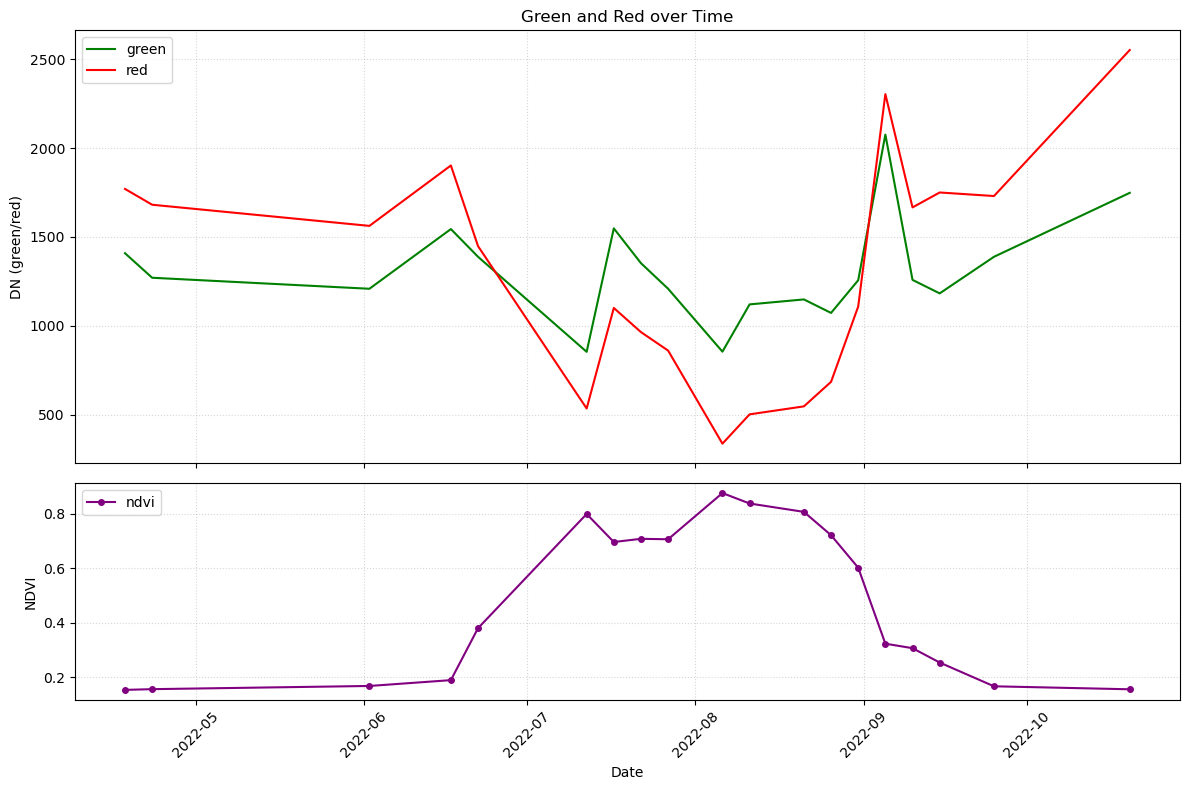

            green   red      ndvi  ndvi_smooth
date                                          
2022-04-18   1408  1770  0.153920     0.190613
2022-04-23   1270  1681  0.156548     0.088334
2022-06-02   1208  1562  0.168264     0.133900
2022-06-17   1544  1902  0.189604     0.275347
2022-06-22   1388  1448  0.380004     0.450064


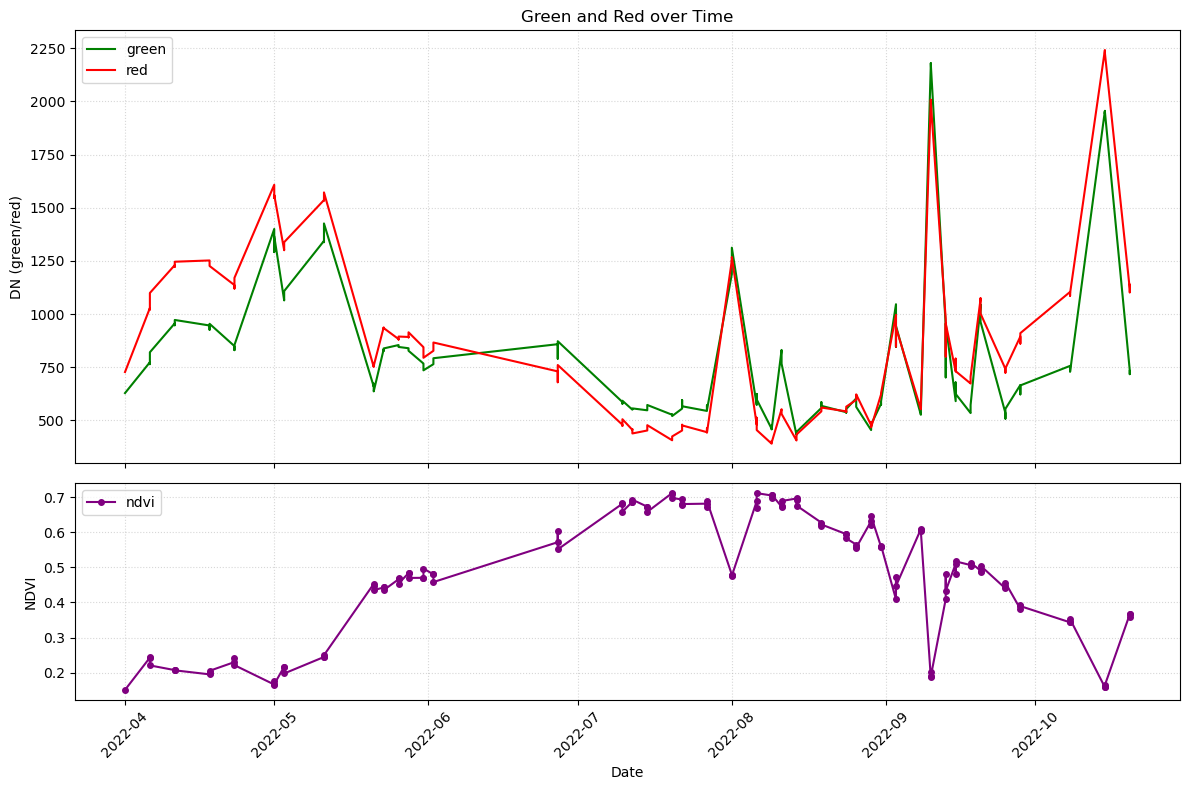

            green   red      ndvi  ndvi_smooth
date                                          
2022-04-01    628   727  0.151197     0.157414
2022-04-06    773  1028  0.243004     0.228325
2022-04-06    764  1021  0.243984     0.246540
2022-04-06    820  1099  0.220844     0.233081
2022-04-11    956  1230  0.207474     0.214646


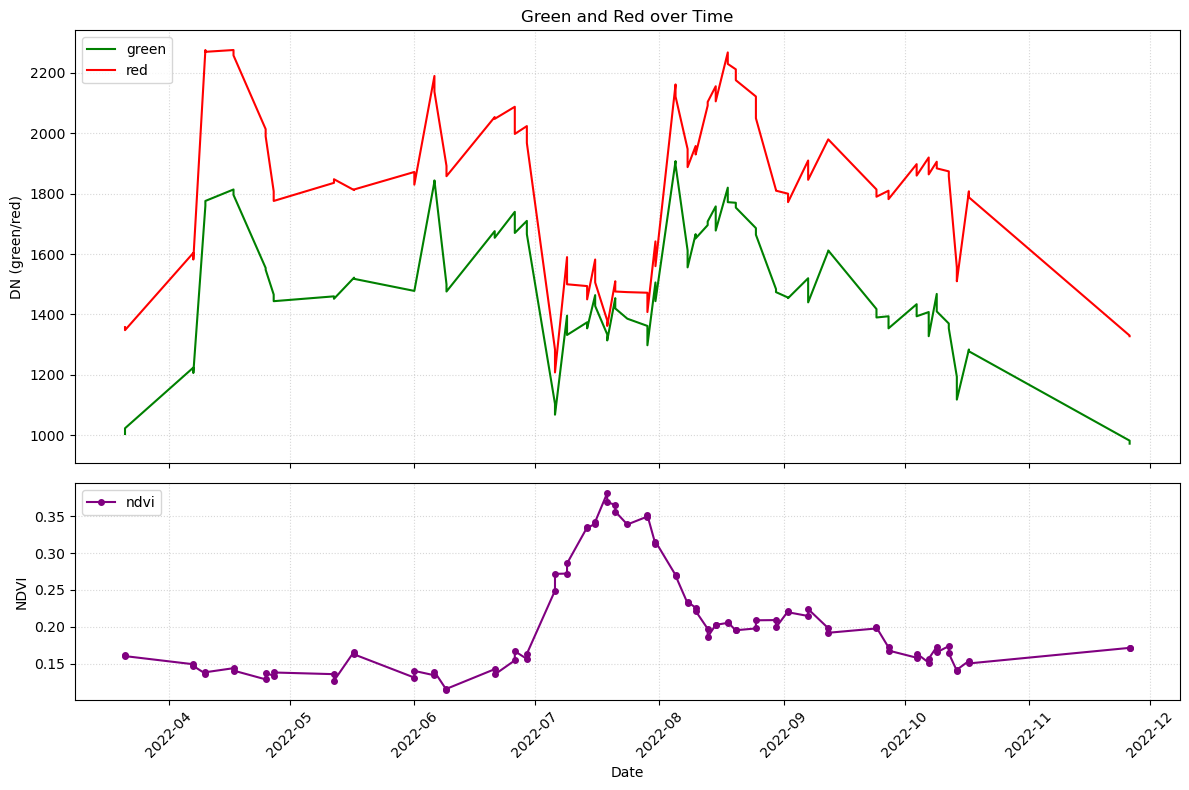

            green   red      ndvi  ndvi_smooth
date                                          
2022-03-21   1004  1358  0.161211     0.161587
2022-03-21   1023  1348  0.160125     0.158572
2022-04-07   1224  1604  0.149072     0.151749
2022-04-07   1206  1582  0.146710     0.143998
2022-04-10   1760  2276  0.136243     0.140014


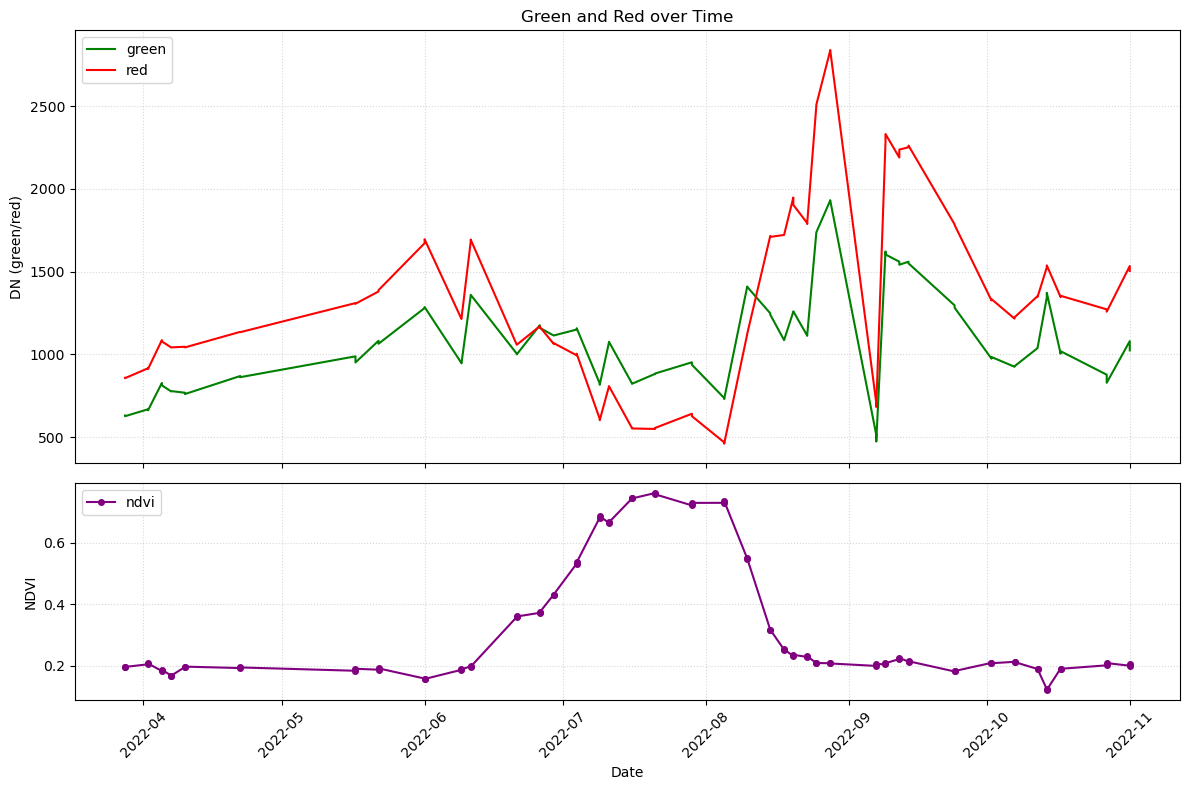

            green   red      ndvi  ndvi_smooth
date                                          
2022-03-28    630   858  0.196629     0.194825
2022-03-28    626   856  0.196244     0.201389
2022-04-02    668   916  0.204861     0.202940
2022-04-02    662   912  0.207646     0.199977
2022-04-05    827  1086  0.182844     0.192370


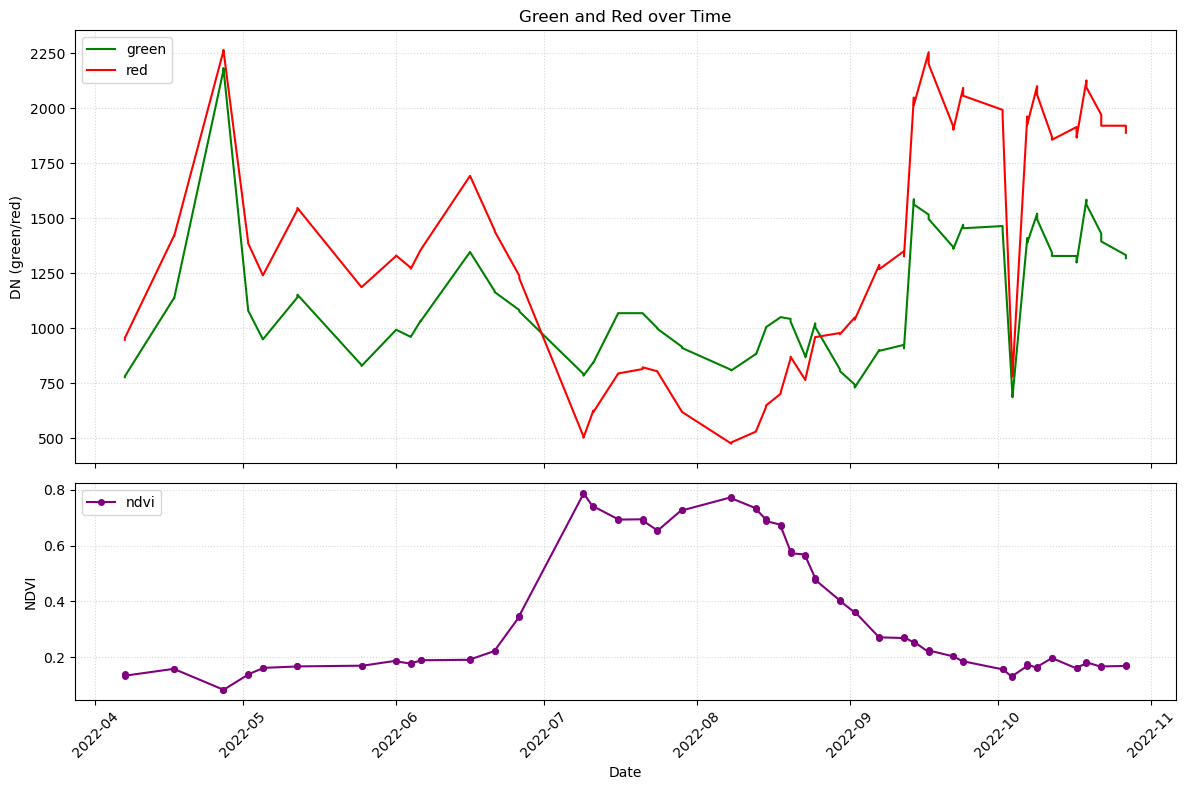

            green   red      ndvi  ndvi_smooth
date                                          
2022-04-07    777   947  0.141043     0.129689
2022-04-07    781   955  0.134180     0.161968
2022-04-17   1138  1421  0.158923     0.154119
2022-04-17   1135  1418  0.158207     0.126616
2022-04-27   2172  2260  0.083908     0.113400


In [29]:
# Load data.json and plot green+red on top, ndvi on bottom (shared x-axis)
import json
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt

# Read the JSON file
with open('data.json', 'r') as f:
    datas = json.load(f)

for data in datas:
    # Create DataFrame
    df = pd.DataFrame({
        'date': pd.to_datetime(data['dates']),
        'green': data['green'],
        'red': data['red'],
        'ndvi': data['ndvi']
    })

    from scipy.signal import savgol_filter
    df['ndvi_smooth'] = savgol_filter(df['ndvi'], window_length=7, polyorder=3)
    # df['ndvi_smooth'] = df['ndvi'].rolling(window=5, center=True, min_periods=1).mean()

    # ndvi_min = df['ndvi_smooth'].min()
    # ndvi_max = df['ndvi_smooth'].max()
    # df['ndvi_norm'] = (df['ndvi_smooth'] - ndvi_min) / (ndvi_max - ndvi_min)

    # Set date index
    df.set_index('date', inplace=True)

    # Create two stacked subplots that share the x-axis
    fig, (ax_top, ax_bottom) = plt.subplots(2, 1, figsize=(12,8), sharex=True,
                                            gridspec_kw={'height_ratios':[2,1]})

    # Top plot: green and red
    ax_top.plot(df.index, df['green'], label='green', color='green')
    ax_top.plot(df.index, df['red'], label='red', color='red')
    ax_top.set_ylabel('DN (green/red)')
    ax_top.legend(loc='upper left')
    ax_top.set_title('Green and Red over Time')
    ax_top.grid(True, linestyle=':', alpha=0.5)

    # Bottom plot: NDVI
    ax_bottom.plot(df.index, df['ndvi'], label='ndvi', color='purple', marker='o', markersize=4)
    # ax_bottom.plot(df.index, df['ndvi_smooth'], color='purple', linewidth=2, label='Smoothed NDVI')
    # ax_bottom.plot(df.index, df['ndvi_norm'], color='blue', linewidth=2, label='Normalized NDVI', alpha=0.5)
    ax_bottom.set_ylabel('NDVI')
    ax_bottom.set_xlabel('Date')
    ax_bottom.legend(loc='upper left')
    ax_bottom.grid(True, linestyle=':', alpha=0.5)

    # ax_bottom.set_xlim(pd.Timestamp('2022-01-01'), pd.Timestamp('2022-12-31'))

    # Improve x-axis date labels
    plt.setp(ax_bottom.get_xticklabels(), rotation=45)
    plt.tight_layout()
    plt.show()

    # Display head of dataframe
    print(df.head())


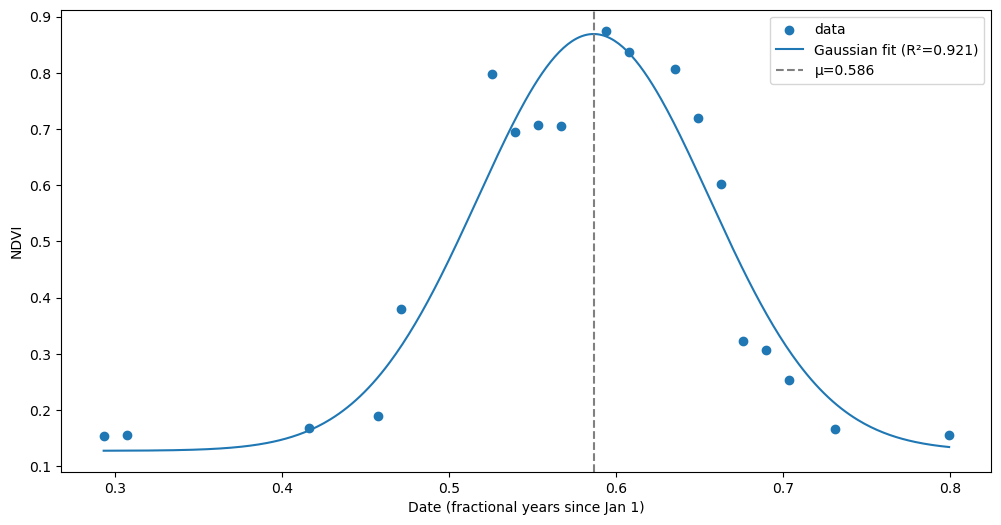

Fitted params: A, mu, sigma, offset = [0.74146224 0.58646952 0.0693631  0.12765139]


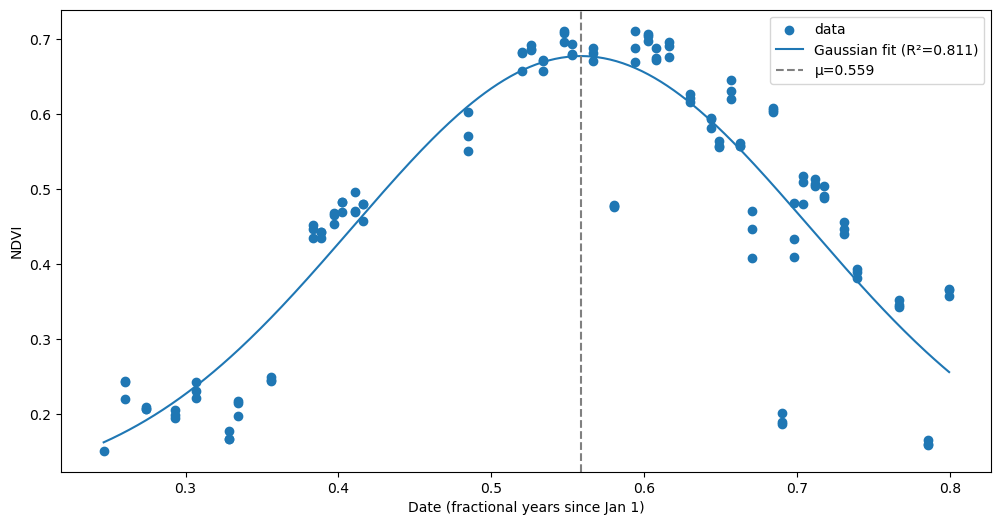

Fitted params: A, mu, sigma, offset = [0.58123608 0.55875306 0.14974771 0.09637984]


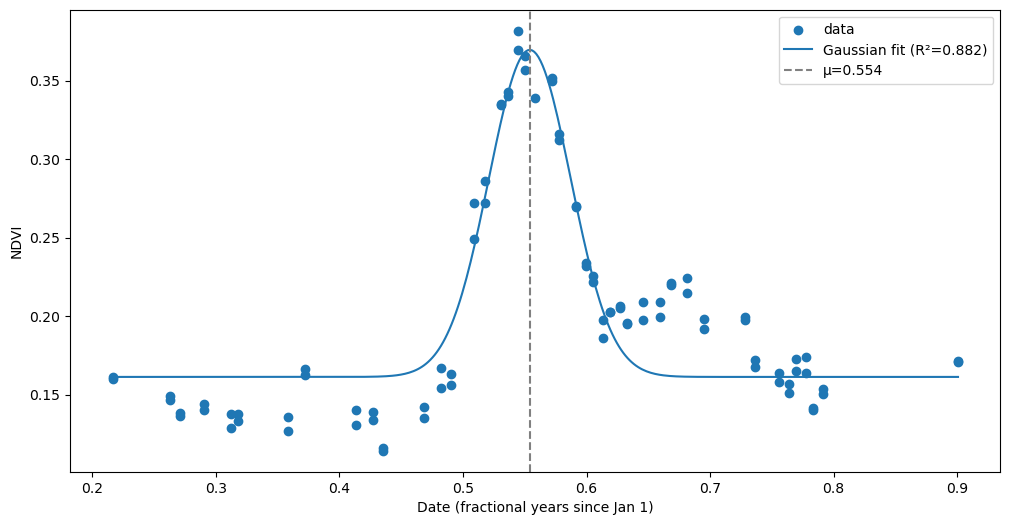

Fitted params: A, mu, sigma, offset = [0.20830352 0.55407011 0.03314074 0.16123373]


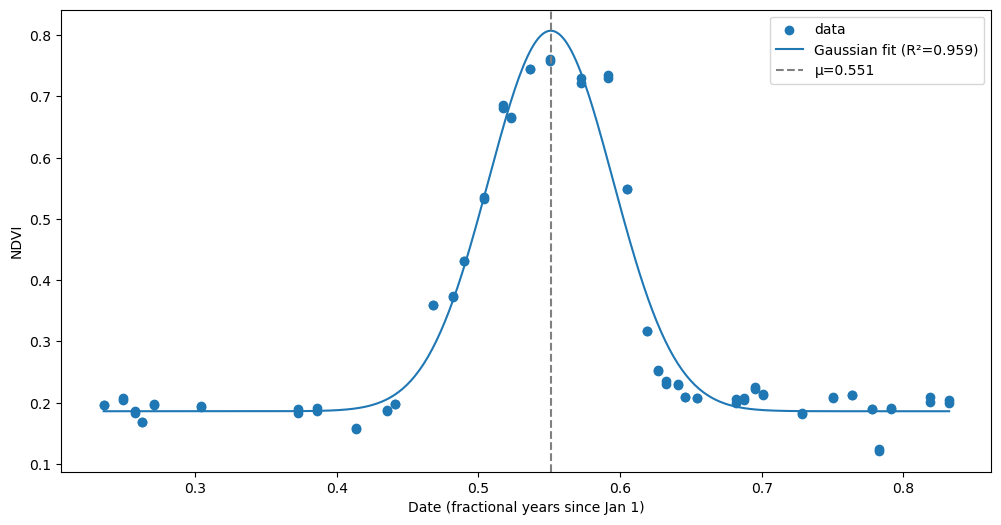

Fitted params: A, mu, sigma, offset = [0.62126411 0.55111816 0.04397699 0.18610519]


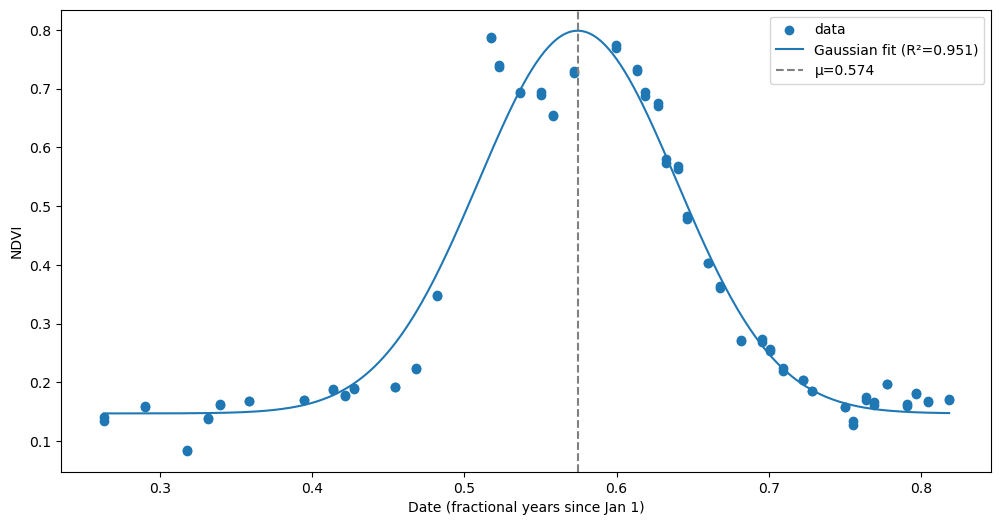

Fitted params: A, mu, sigma, offset = [0.65165605 0.57442923 0.06515553 0.14689629]


In [30]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

for data in datas:
    df = pd.DataFrame({
        'date': pd.to_datetime(data['dates']),
        'green': data['green'],
        'red': data['red'],
        'ndvi': data['ndvi']
    })

    df.set_index('date', inplace=True)
    
    # Example discrete data (replace x_data,y_data with your own)
    # x_data = df.index.map(datetime.toordinal).to_numpy()
    # x_data = (x_data - x_data.min()) / 365.25  # normalize
    # x_data = (df.index - df.index.min()).to_series().dt.total_seconds().to_numpy() / (3600.0 * 24.0 * 365.25)
    start_of_year = pd.Timestamp(year=df.index.min().year, month=1, day=1)
    x_data = (df.index.to_series() - start_of_year).dt.total_seconds().to_numpy() / (3600.0 * 24.0 * 365.25)  # fractional years since Jan 1

# ...existing code...
    # synthetic noisy bell
    y_true = 5.0 * np.exp(-0.5 * ((x_data - 5.2) / 0.9)**2)
    rng = np.random.default_rng(0)
    y_data = df['ndvi'].to_numpy()

    # Gaussian model
    def gaussian(x, A, mu, sigma, offset):
        return A * np.exp(-0.5 * ((x - mu) / sigma)**2) + offset

    # initial guesses: amplitude, center, sigma, offset
    A0 = np.max(y_data) - np.min(y_data)
    mu0 = x_data[np.argmax(y_data)]
    # rough FWHM estimate: span where y > half max
    half = np.min(y_data) + 0.5 * (np.max(y_data) - np.min(y_data))
    indices = np.where(y_data > half)[0]
    if len(indices) >= 2:
        fwhm = x_data[indices[-1]] - x_data[indices[0]]
    else:
        fwhm = (x_data[-1] - x_data[0]) / 4.0
    sigma0 = fwhm / (2.0 * np.sqrt(2.0 * np.log(2.0)))
    p0 = [A0, mu0, max(sigma0, 1e-3), np.min(y_data)]

    # bounds (optional)
    lower = [0.0, x_data.min(), 1e-6, -np.inf]
    upper = [np.inf, x_data.max(), np.inf, np.inf]

    popt, pcov = curve_fit(gaussian, x_data, y_data, p0=p0, bounds=(lower, upper))
    A_fit, mu_fit, sigma_fit, offset_fit = popt

    # goodness-of-fit (R^2)
    residuals = y_data - gaussian(x_data, *popt)
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y_data - np.mean(y_data))**2)
    r2 = 1 - ss_res/ss_tot

    # plot
    xx = np.linspace(x_data.min(), x_data.max(), 400)
    yy_fit = gaussian(xx, *popt)

    fig, ax = plt.subplots(figsize=(12,6), dpi=100)   # width=8in, height=3in; adjust as needed
    plt.scatter(x_data, y_data, label='data')
    plt.plot(xx, yy_fit, label=f'Gaussian fit (R²={r2:.3f})')
    plt.axvline(mu_fit, color='gray', ls='--', label=f'μ={mu_fit:.3f}')
    plt.ylabel('NDVI')
    plt.xlabel('Date (fractional years since Jan 1)')
    plt.legend()
    # plt.xlim(0, 1)
    plt.show()

    print("Fitted params: A, mu, sigma, offset =", popt)


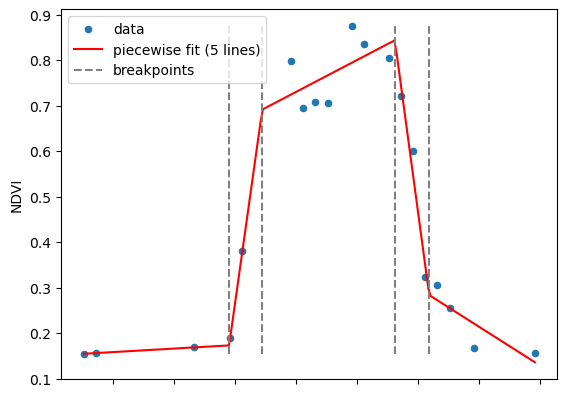

Breakpoints: [738263.         738322.56170665 738336.17577468 738390.55808417
 738404.66461685 738448.        ]
Slopes: [ 0.00030898  0.03811355  0.00280425 -0.03974937 -0.00340939]


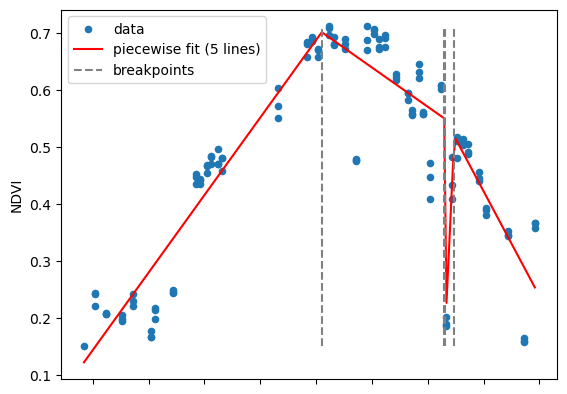

Breakpoints: [738246.         738352.53753013 738407.41064346 738407.90530826
 738411.93205457 738448.        ]
Slopes: [ 0.00543057 -0.00275238 -0.7385224   0.08289007 -0.00733993]


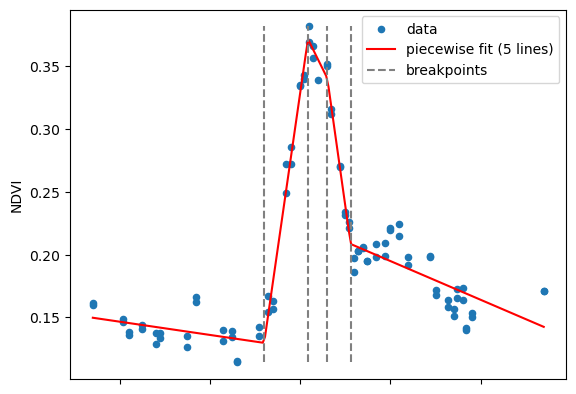

Breakpoints: [738235.         738329.98518451 738354.27320297 738364.99999818
 738377.96969853 738485.        ]
Slopes: [-0.00021069  0.00995844 -0.00290533 -0.01017708 -0.00061617]


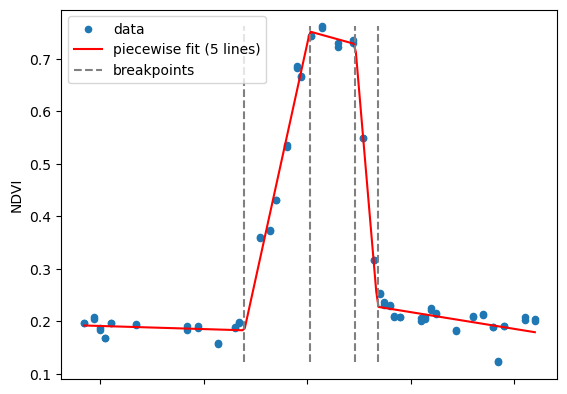

Breakpoints: [738242.         738319.5390301  738351.24229967 738373.13160976
 738383.94177977 738460.        ]
Slopes: [-0.00011892  0.01795316 -0.00108979 -0.04629482 -0.00063714]


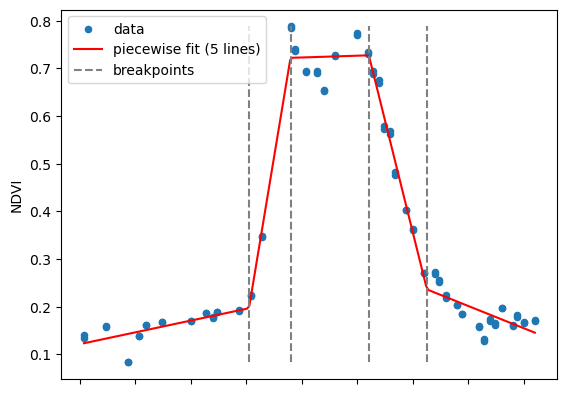

Breakpoints: [738252.         738326.29026285 738345.00000001 738380.25460725
 738406.43024751 738455.        ]
Slopes: [ 0.0009887   0.02808484  0.00014924 -0.01876789 -0.00186801]


In [31]:
import numpy as np
import matplotlib.pyplot as plt
import pwlf  # pip install pwlf

for data in datas:
    df = pd.DataFrame({
        'date': pd.to_datetime(data['dates']),
        'green': data['green'],
        'red': data['red'],
        'ndvi': data['ndvi']
    })

    df.set_index('date', inplace=True)

    # Example data roughly bell-shaped
    x = x_data = df.index.map(datetime.toordinal).to_numpy()
    x_data = (x_data - x_data.min()) / 365.25  # normalize
    # start_of_year = pd.Timestamp(year=df.index.min().year, month=1, day=1)
    # x_data = (df.index.to_series() - start_of_year).dt.total_seconds().to_numpy() / (3600.0 * 24.0 * 365.25)  # fractional years since Jan 1
    y = y_data = df['ndvi'].to_numpy()

    # Fit 3-segment piecewise linear model
    my_pwlf = pwlf.PiecewiseLinFit(x, y)
    breaks = my_pwlf.fit(5)  # 3 segments → 2 internal breakpoints

    # Predictions
    x_hat = np.linspace(x.min(), x.max(), 200)
    y_hat = my_pwlf.predict(x_hat)

    # Plot
    plt.scatter(x, y, s=20, label='data')
    plt.plot(x_hat, y_hat, 'r-', label='piecewise fit (5 lines)')
    plt.vlines(breaks[1:-1], y.min(), y.max(), color='gray', ls='--', label='breakpoints')
    plt.ylabel('NDVI')
    # plt.xlabel('Date (fractional years since Jan 1)')
    plt.tick_params(labelbottom=False)
    plt.legend()
    plt.show()

    print("Breakpoints:", breaks)
    print("Slopes:", my_pwlf.slopes)


## Merging datasets

In [32]:
import ee
import geemap

def sample_point_merge(img, aoi):
    # Sample each image at a point and bring results to pandas
    # Note: geemap.ee_to_df expects an ee.FeatureCollection. Mapping a function
    # over an ImageCollection that returns Features still yields an ImageCollection,
    # so we explicitly wrap the mapped results with ee.FeatureCollection(...).

    # Compute mean over the AOI for each image. Use bestEffort to avoid failures
    # on very large geometries.
    mean = img.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=aoi,
        scale=10,
        bestEffort=True,
    )
    # Return a Feature with the band's mean values and the image date.
    return ee.Feature(aoi, mean).set('date', img.date().format('YYYY-MM-dd'))

ee.Initialize()

s2 = (
    ee.ImageCollection("COPERNICUS/S2_SR")
)
l8 = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2")

# Filter both by date and region
region = ee.Geometry.Point([-120.5, 37.5])
start = '2023-05-01'
end = '2023-08-01'

s2_filtered = s2.filterBounds(region).filterDate(start, end)
l8_filtered = l8.filterBounds(region).filterDate(start, end)

# Merge the two collections
combined = s2_filtered.merge(l8_filtered)
combined = ee.FeatureCollection(s2_filtered.map(lambda img: sample_point_merge(img, region)))

df = geemap.ee_to_df(combined)
print("Combined ImageCollection:", df)


/Users/ben/opt/anaconda3/envs/nasa/lib/python3.13/site-packages/ee/deprecation.py:209: DeprecationWarning: 

Attention required for COPERNICUS/S2_SR! You are using a deprecated asset.
To make sure your code keeps working, please update it.
Learn more: https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR

  warnings.warn(warning, category=DeprecationWarning)


Combined ImageCollection:     AOT     B1   B11   B12     B2     B3     B4     B5     B6     B7  ...  \
0    96   1696  2075  1765   1593   1590   1687   1728   1815   1886  ...   
1   126   9593  3524  3542   9392   9040   8992   9646   9328   9150  ...   
2   114   4961  4349  3865   4864   4756   4628   4899   5207   5217  ...   
3   354   3428  2979  2650   3238   3252   3218   3580   3916   4024  ...   
4   258   1593  3920  3582   1811   2130   2556   2845   2895   3017  ...   
5   144   1611  3959  3706   1850   2168   2620   2830   2927   3087  ...   
6   288   1767  4370  3963   1925   2376   2926   3177   3290   3429  ...   
7   138   1511  3405  3177   1619   1890   2244   2413   2504   2605  ...   
8   288   1623  3999  3844   1830   2152   2656   2857   2863   3037  ...   
9   186   1560  3559  3383   1745   2006   2376   2553   2673   2794  ...   
10  414   1698  4103  3802   1830   2254   2804   3000   2963   3099  ...   
11  384   1739  3932  3566   1835   2212   2678   

In [33]:
df.head()

,AOT,B1,B11,B12,B2,B3,B4,B5,B6,B7,...,MSK_SNWPRB,QA10,QA20,QA60,SCL,TCI_B,TCI_G,TCI_R,WVP,date
0,96,1696,2075,1765,1593,1590,1687,1728,1815,1886,...,0,0,0,0,3,61,60,70,1021,2023-05-01
1,126,9593,3524,3542,9392,9040,8992,9646,9328,9150,...,0,0,0,0,8,255,255,255,1675,2023-05-04
2,114,4961,4349,3865,4864,4756,4628,4899,5207,5217,...,0,0,0,0,9,255,255,255,1343,2023-05-06
3,354,3428,2979,2650,3238,3252,3218,3580,3916,4024,...,0,0,0,0,8,228,229,226,1350,2023-05-09
4,258,1593,3920,3582,1811,2130,2556,2845,2895,3017,...,0,0,0,0,5,81,116,161,1151,2023-05-11


In [34]:
ndvi = (ee.ImageCollection("MODIS/006/MOD13A2")
    .select("NDVI")
    .filterDate('2023-05-01', '2023-05-31')
    .mean()
)

lst = (ee.ImageCollection("ECMWF/ERA5_LAND/HOURLY")
    .select("temperature_2m")
    .filterDate('2023-05-01', '2023-05-31')
    .mean()
)

combined = ndvi.addBands(lst)
print("Combined image:", combined.getInfo())

combined = ee.FeatureCollection(s2_filtered.map(lambda img: sample_point_merge(img, region)))
df = geemap.ee_to_df(combined)


/Users/ben/opt/anaconda3/envs/nasa/lib/python3.13/site-packages/ee/deprecation.py:209: DeprecationWarning: 

Attention required for MODIS/006/MOD13A2! You are using a deprecated asset.
To make sure your code keeps working, please update it.
Learn more: https://developers.google.com/earth-engine/datasets/catalog/MODIS_006_MOD13A2

  warnings.warn(warning, category=DeprecationWarning)


Combined image: {'type': 'Image', 'bands': [{'id': 'temperature_2m', 'data_type': {'type': 'PixelType', 'precision': 'double'}, 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}]}


In [35]:
df.head()

,AOT,B1,B11,B12,B2,B3,B4,B5,B6,B7,...,MSK_SNWPRB,QA10,QA20,QA60,SCL,TCI_B,TCI_G,TCI_R,WVP,date
0,96,1696,2075,1765,1593,1590,1687,1728,1815,1886,...,0,0,0,0,3,61,60,70,1021,2023-05-01
1,126,9593,3524,3542,9392,9040,8992,9646,9328,9150,...,0,0,0,0,8,255,255,255,1675,2023-05-04
2,114,4961,4349,3865,4864,4756,4628,4899,5207,5217,...,0,0,0,0,9,255,255,255,1343,2023-05-06
3,354,3428,2979,2650,3238,3252,3218,3580,3916,4024,...,0,0,0,0,8,228,229,226,1350,2023-05-09
4,258,1593,3920,3582,1811,2130,2556,2845,2895,3017,...,0,0,0,0,5,81,116,161,1151,2023-05-11


In [36]:
import pandas as pd

filter_list = [0.7, 0.9, 0.3]

# Example DataFrame
df = pd.DataFrame({
    'crop': ['corn', 'wheat', 'rice', 'corn', 'soy'],
    'ndvi': [0.7, 0.5, 0.9, 0.3, 0.6],
    'rainfall': [100, 80, 120, 60, 90]
})

# Filter: keep only rows where NDVI > 0.6
filtered = df[df['ndvi'].isin(filter_list)]
print(filtered)


   crop  ndvi  rainfall
0  corn   0.7       100
2  rice   0.9       120
3  corn   0.3        60
